In [0]:
from sklearn.datasets import load_breast_cancer  # 데이터셋 로드
from sklearn.model_selection import train_test_split  # 훈련셋이랑 검증셋 분리

In [0]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
# 데이터 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

In [5]:
x_train , x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))  # val : validation set

364 91


In [7]:
from sklearn.linear_model import SGDClassifier

# 검증 세트 사용해 모델 평가하기
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

데이터의 스케일? 

특성이 가지고 있는 값의 범위를 말함. 특성의 스케일을 전처리 하는 것을 스케일을 조정한다는 표현으로 사용.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

['mean perimeter' 'mean area']


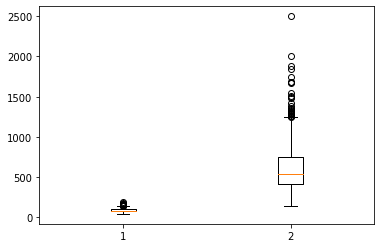

In [9]:
print(cancer.feature_names[[2,3]])
# 박스플롯
plt.boxplot(x_train[:, 2:4])  # 2에서 4행의 모든 열
plt.show()

두 특성의 스케일은 차이가 크다(100 ~ 200 과 200 ~ 2,000)

In [0]:
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w = None  # weight 가중치
        self.b = None  # bias 바이어스
        self.losses = []  # 손실을 누적
        self.w_history = []  # 가중치 변화 누적하는 리스트
        self.lr = learning_rate  # 학습률(hyperparameter)

    def forpass(self, x):
        # 정방향 진행
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, error):
        # 역방향 진행
        w_g = x * error
        b_g = 1 * error
        return w_g, b_g

    def add_bias(self, x):
        # 1로 채워진 열백터를 추가하는. 
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z):
        # 활성화 함수
        a = 1 / (1 + np.exp(-z))
        return a 

    def fit(self, x, y, epochs=100):
        # 가중치랑 바이어스를 초기화
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())  # 가중치를 복사해서 기록(numpy 배열은 복사해서 넣어줘야 함)

        np.random.seed(42)  # 무작위로 시드 지정
        for i in range(epochs):
            loss = 0
            # 인덱스 섞기
            indexs = np.random.permutation(np.arange(len(x)))
            for j in indexs:
                z = self.forpass(x[j])  # 정방향 계산
                a = self.activation(z)  # 활성화 함수 적용
                err = -(y[j] - a)  # 오차 계산
                w_grad, b_grad = self.backprop(x[j], err)  # 역방향 계산
                self.w -= self.lr * w_grad  # 학습률을 곱해서 가중치 업데이트
                self.b -= b_grad
                self.w_history.append(self.w.copy())  # 가중치 기록
                a = np.clip(a, 1e-10, 1-1e-10)  # 로그 계산을 위한 클리핑
                loss += -(y[j]*np.log(a) * (1-y[j])*np.log(1-a))
            self.losses.append(loss/len(y))  # 평균 손실 저장

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y)

In [13]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


0.9120879120879121

스케일을 조정하지 않은 훈련세트를 사용한 모델 훈련 : 91 퍼센트

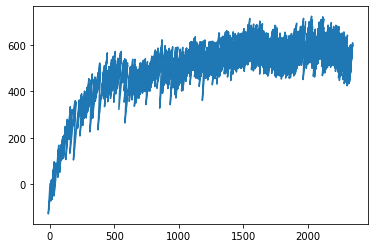

In [15]:
w2 = []  # mean perimeter 특성에 대한 가중치
w3 = []  # mean area 특성에 대한 가중치
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1])

### 스케일 조정하는 방법?

표준화
 z = (x-u)/s

In [0]:
# 표준화 구현하기, axis를 0으로 지정하면 2차원 배열의 열을 기준으로 통계치 계산 후 하나의 행 벡터로 반환. 
train_mean = np.mean(x_train, axis=0)
train_sta = np.std(x_train, axis=0)  # standard diviation
x_train_scaled = (x_train - train_mean) / train_sta

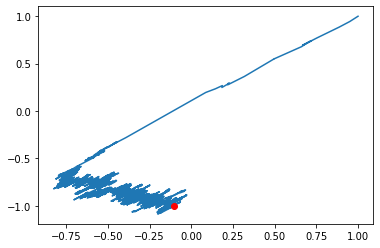

In [24]:
# 표준화된 데이터셋으로 모델 훈련하기 
ly2 = SingleLayer()
ly2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in ly2.w_history: # 다시 가중치 계산
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1],'ro') # 빨간점이 최종!

w2와 w3의 변화 비율이 비슷 > 대각선 방향으로 가중치가 이동됨. 

In [22]:
ly2.score(x_val, y_val)

0.37362637362637363

검증세트의 표준화를 거치지 않음

In [23]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std
# 검증세트의 표준화 완료!
ly2.score(x_val_scaled, y_val)

0.967032967032967

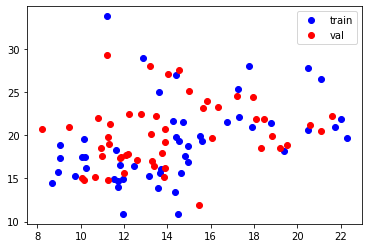

In [25]:
# 원본 훈련셋과 검증셋을 비교해보기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')  # 훈련셋
plt.plot(x_val[:50, 0], x_val[:50, 1],'ro')  # 검증셋
plt.legend(['train', 'val'])

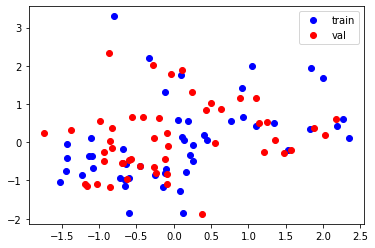

In [28]:
# 전처리된 훈련셋과 검증셋을 비교해보기
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.legend(['train', 'val'])

데이터 전처리를 제대로 하기?

훈련세트의 표준편차로 검증셋을 전차리 하기!

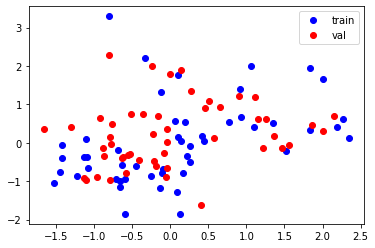

In [30]:
# 훈련세트의 평균과 표준편차로 검증셋을 전처리 했다
x_val_scaled = (x_val - train_mean) / train_sta
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.legend(['train', 'val'])

In [31]:
ly2.score(x_val_scaled, y_val)

0.967032967032967

# 과대적합? 과소적합??
